In [8]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from fastdtw import fastdtw

In [9]:
LENGTH = 22000
OFFSET = 4000

In [10]:
def get_signals(dir, max_no_signals = 10):
    '''
    gets signals from specified directory 
    and returns a (n, l, 1) numpy array
    where n is number of distinct signals and
    l is length of each signal.
    '''
    directory = dir

    list_of_signals = []

    n = 0

    for filename in os.listdir(directory):
        filename = directory + '/' + filename
        list_of_signals.append(np.genfromtxt(filename, delimiter=','))
        n+=1
    
    no_signals = len(list_of_signals) # comment out if doing subsampling for testing
    
    signals = np.zeros([no_signals-1, LENGTH])   # replace 5 with n ! 
    
    for i, arr in enumerate(list_of_signals[1:(no_signals-1)]):
        arr = arr[OFFSET:LENGTH+OFFSET]
        signals[i][0:arr.shape[0]] = arr

    print("Signals loaded. Length of a signal is %d, No. of signals is: %d" % (len(signals[0]), no_signals-1))
    return signals, no_signals - 1

def plot_signals(signals, name):
    avg = np.average(signals, axis=0)
    std = np.std(signals, axis=0)
    x = range(signals.shape[1])

    plt.style.use('ggplot') #Change/Remove This If you Want
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(x, avg, alpha=0.5, color='red', label=name, linewidth = 1.0)
    ax.fill_between(x, avg - std, avg + std, color='#888888', alpha=0.4)
    ax.fill_between(x, avg - 2*std, avg + 2* std, color='#888888', alpha=0.2)
    ax.legend(loc='best')
    ax.set_ylabel("Signal units?")
    ax.set_xlabel("Time")
    plt.show()
    
def plot_sig(sigs, n=10):
    plt.figure(figsize=(15,10))
    for sig in sigs[0:n]:
        plt.plot(sig)
    plt.show()

In [11]:
div = 100

def downsample(s, R):
    s = s.reshape(-1, R)
    return s.reshape(-1, R).mean(axis=1)

def downsample_signals(signals):
    downsampled_signals = np.zeros([signals.shape[0], LENGTH//div])
    
    for i, signal in enumerate(signals):
        downsampled_signals[i] = downsample(signal, div)
        
    return downsampled_signals

Signals loaded. Length of a signal is 22000, No. of signals is: 98


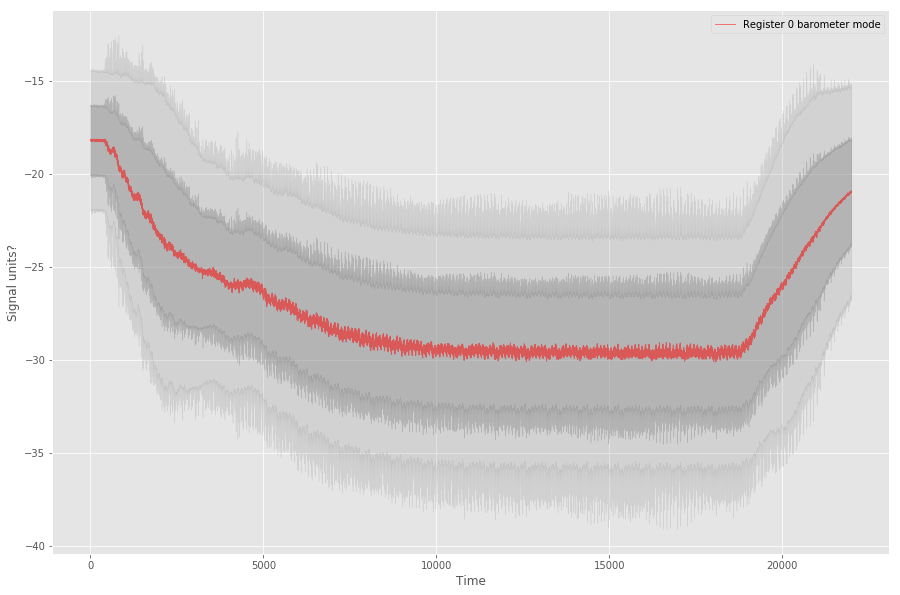

In [13]:
reg0_bar, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-0-bar-mode')
plot_signals(reg0_bar, 'Register 0 barometer mode')

Signals loaded. Length of a signal is 22000, No. of signals is: 98


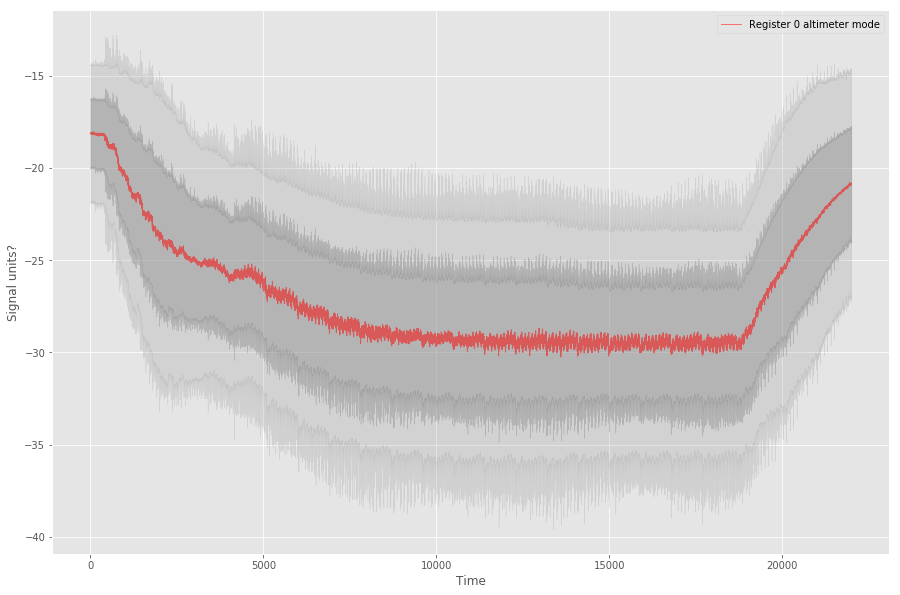

In [14]:
reg0_alt, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-0-alt-mode')
plot_signals(reg0_alt, 'Register 0 altimeter mode')

Signals loaded. Length of a signal is 22000, No. of signals is: 374


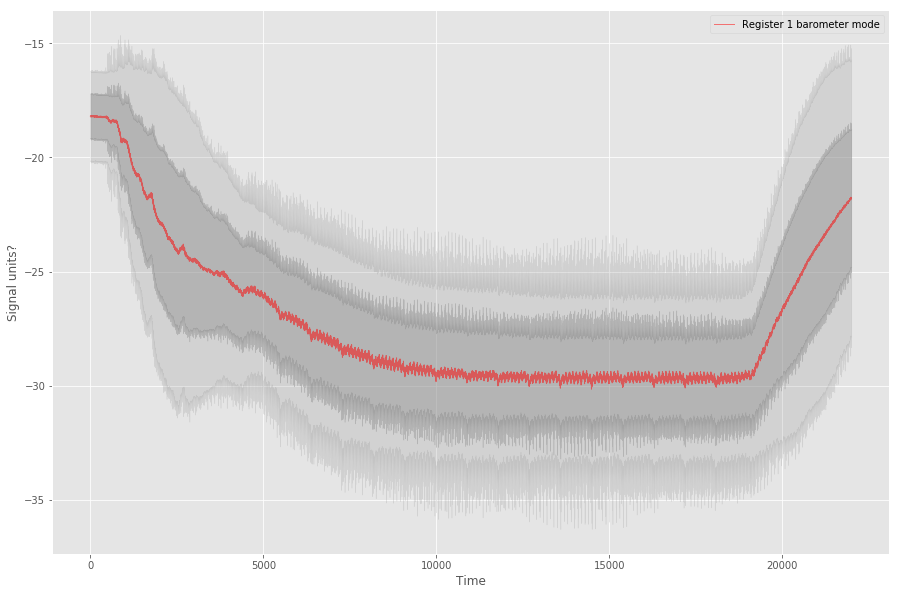

In [15]:
reg1_bar, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-1-bar-mode')
plot_signals(reg1_bar, 'Register 1 barometer mode')

Signals loaded. Length of a signal is 22000, No. of signals is: 362


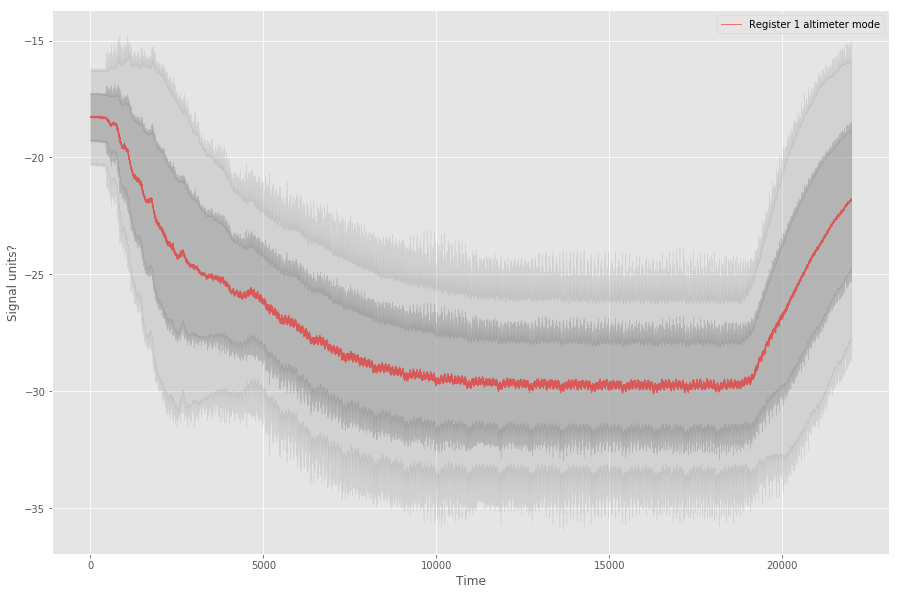

In [16]:
reg1_alt, _ = get_signals('../Scripts/Applications/Data_processing/MPL-REG-1-alt-mode')
plot_signals(reg1_alt, 'Register 1 altimeter mode')

In [17]:
def dtw(x, y):
    distance, path = fastdtw(x, y, dist=1)
    return distance


In [18]:
reg1_bar_downsampled = downsample_signals(reg1_bar)
reg1_alt_downsampled = downsample_signals(reg1_alt)
print("REG 1")
for i in range(1,5):
    print(dtw(reg1_bar_downsampled[10], reg1_bar_downsampled[i]))
print("--------------")
for i in range(1,5):
    print(dtw(reg1_bar_downsampled[10], reg1_alt_downsampled[i]))
print("=======REG 0=======")

reg0_bar_downsampled = downsample_signals(reg0_bar)
reg0_alt_downsampled = downsample_signals(reg0_alt)

for i in range(1,5):
    print(dtw(reg0_bar_downsampled[10], reg0_bar_downsampled[i]))
print("--------------")
for i in range(1,5):
    print(dtw(reg0_bar_downsampled[10], reg0_alt_downsampled[i]))

REG 1
183.04907226518202
43.925659178566036
92.59790039170689
36.81823730542804
--------------
159.93432617057198
83.9442138671019
38.87646484395792
42.83422851490208
=======REG 0=======
43.17517089820686
42.40026855411699
76.63183593760704
22.185546876787047
--------------
36.757934569486835
60.6575927745489
95.57617187544592
36.42468261825697


/home/johnny/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  


In [21]:
from keras.models import Sequential, Model
from keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D, GlobalAveragePooling1D, Input, UpSampling1D
from keras.utils import to_categorical
from keras import regularizers

Using TensorFlow backend.


In [19]:
# create train/test split (3/4)

size=200
x = np.concatenate((downsample_signals(reg1_bar[0:size]), downsample_signals(reg1_alt[0:size])),axis=0)
                    #downsample_signals(reg0_bar[0:size]), downsample_signals(reg0_alt[0:size])),axis=0)
x0 = np.concatenate((downsample_signals(reg0_bar[0:size]), downsample_signals(reg0_alt[0:size])),axis=0)
    
y1 = np.zeros(size)
y2 = np.ones(size)
y3 = np.ones(size)+1
y4 = np.ones(size)+2
#y = to_categorical(np.concatenate((y1,y2,y3,y4)))
y = np.concatenate((y1,y2)).reshape(-1,1)

print(x.shape)
print(y.shape)

def split(arr, n = len(x) - len(x)//4):
    return arr[:n], arr[n:]

def random_split(x, y, dim_out=1):
    """shuffle data, train/test split. returns train_x, train_y, test_x, test_y"""
    tmp = np.concatenate((x,y), axis=1)
    np.random.shuffle(tmp)
    train, test = split(tmp)
    return train[:,:-dim_out], train[:,-dim_out:], test[:,:-dim_out], test[:,-dim_out:]

train_x, train_y, test_x, test_y = random_split(x,y, y.shape[1])

seq_length, n_features, n_outputs = train_x.shape[1], 1, y.shape[1]
print("Sequence length is", seq_length)

train_x = train_x.reshape(-1,seq_length, n_features)
test_x = test_x.reshape(-1, seq_length, n_features)
print(train_x.shape)
print(train_y.shape)

(400, 220)
(400, 1)
Sequence length is 220
(300, 220, 1)
(300, 1)


In [22]:
verbose, epochs, batch_size = 1, 10, 8

model = Sequential((
    # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
    # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
    # the input timeseries, the activation of each filter at that position.
    Conv1D(filters=16, kernel_size=10, activation='relu', input_shape=(seq_length, n_outputs)),
    MaxPooling1D(),     # Downsample the output of convolution by 2X.
    Conv1D(filters=16, kernel_size=10, activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(n_outputs, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = True)

Epoch 1/10
300/300 [==============================] - 0s 961us/step - loss: 0.9234 - acc: 0.5700
Epoch 2/10
300/300 [==============================] - 0s 377us/step - loss: 0.8056 - acc: 0.4733
Epoch 3/10
300/300 [==============================] - 0s 381us/step - loss: 0.7187 - acc: 0.5233
Epoch 4/10
300/300 [==============================] - 0s 429us/step - loss: 0.7781 - acc: 0.4333
Epoch 5/10
300/300 [==============================] - 0s 440us/step - loss: 0.7460 - acc: 0.4367
Epoch 6/10
300/300 [==============================] - 0s 416us/step - loss: 0.7222 - acc: 0.5000
Epoch 7/10
300/300 [==============================] - 0s 427us/step - loss: 0.7237 - acc: 0.4767
Epoch 8/10
300/300 [==============================] - 0s 415us/step - loss: 0.7129 - acc: 0.4267
Epoch 9/10
300/300 [==============================] - 0s 415us/step - loss: 0.7073 - acc: 0.4600
Epoch 10/10
300/300 [==============================] - 0s 424us/step - loss: 0.7102 - acc: 0.4933


In [54]:
_, accuracy = model.evaluate(train_x, train_y, batch_size=batch_size, verbose=0)
print(accuracy)
# evaluate model
_, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
print(accuracy)

0.4866666666666667
0.54


In [24]:
from sklearn.cluster import DBSCAN
clus= DBSCAN(eps=60, min_samples=3, metric=dtw).fit(x)

/home/johnny/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  
/home/johnny/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  


In [25]:
unique, counts = np.unique(clus.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 400}

Cluster 0 number of entries 400


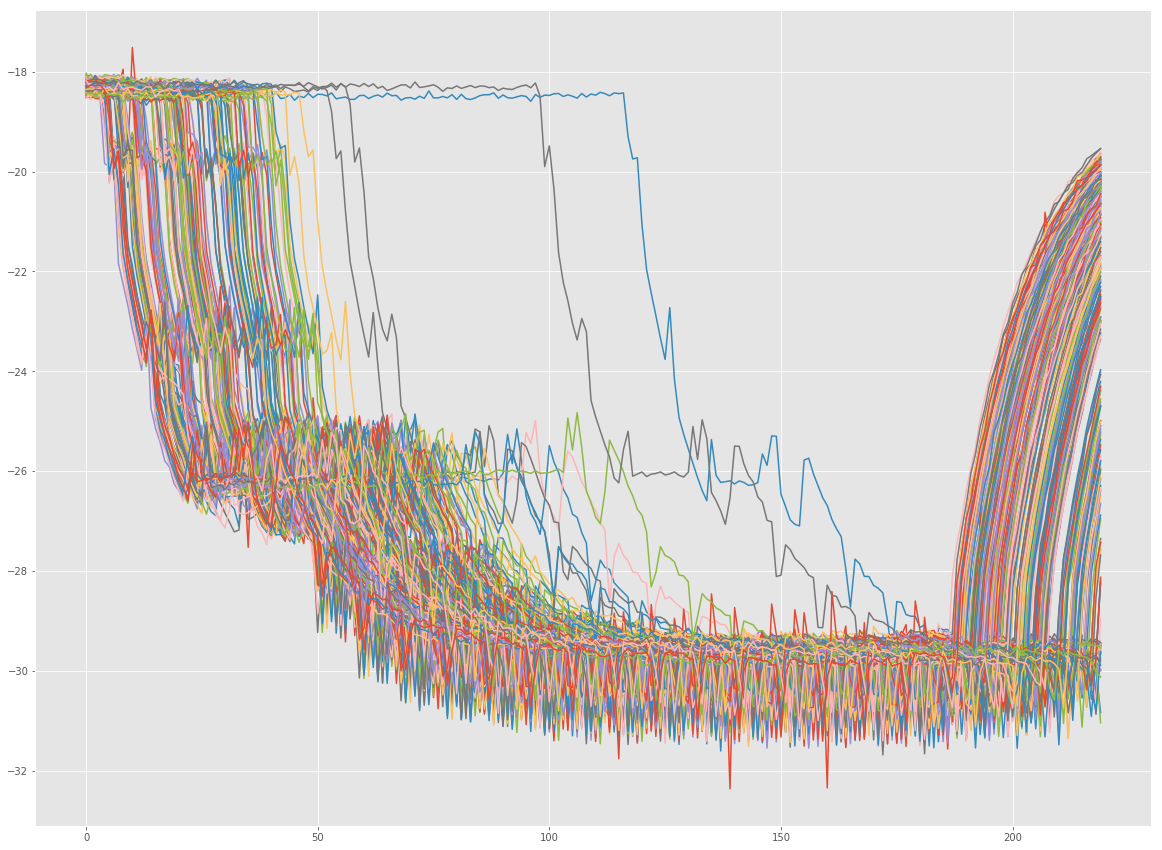

In [26]:
def plot_clusters(data, labels):
    import pandas as pd

    timeSeries = pd.DataFrame(data = data)

    # check the results
    s = pd.Series(labels)
    clusters = s.unique()

    for c in clusters:
        cluster_indices = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indices)))
        timeSeries.T.iloc[:,cluster_indices].plot(figsize=(20,15), legend=False)
        plt.show()
        
plot_clusters(x, clus.labels_)